# Effects of the Size of the Blocking Sphere on Aggregation

## Required Imports

In [2]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt

from blockingsphere import Fish

from interaction import Interaction
from environment import Environment
from channel import Channel
from observer import Observer
from dynamics import Dynamics

from utils import generate_distortion, generate_fish, run_simulation

## Blocking Sphere and Aggregation

Change the radius of the blocking sphere `r_blocking` surrounding each BlueBot. `r_blocking=0` means no blocking at all, i.e. transparent BlueBots. `r_blocking=65` represents the actual blocking sphere surrounding the BlueBot. `r_blocking>65` means an inflated blocking sphere, severely worsening occlusion and limiting the visibility of neighbors.

Observe the effects of the blocking sphere on how well the fish aggregate, described by there mean neighbor distance and mean speeds after a given `run_time`.

Please forgive and re-run if you get a currently unexplicable math domain error.

In [74]:
r_blocking = 65 # [mm]

run_time = 15 # in seconds
num_fish = 25
arena_size = np.array([1780, 1780, 1170])
arena_center = arena_size / 2.0
initial_spread = (2*1780**2)**(1/2)
fish_pos = initial_spread * np.random.rand(num_fish, 3) + arena_center - initial_spread / 2.0
fish_vel = np.zeros((num_fish, 3))
fish_phi = math.pi * np.random.rand(num_fish, 1)
fish_vphi = np.zeros((num_fish, 1))
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', magnitude=130, n=math.ceil(arena_size[0]/10)+1, show=False)
environment = Environment(
    arena_size=arena_size,
    node_pos=fish_pos,
    node_vel=fish_vel,
    node_phi=fish_phi,
    node_vphi=fish_vphi,
    distortion=distortion,
    prob_type='binary',
    conn_thres=3000,
    conn_drop=1,
    noise_magnitude=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)
dynamics = Dynamics(environment, clock_freq=clock_freqs)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction,
    dynamics=dynamics,
    w_blindspot=50,
    r_blocking=r_blocking,
    target_dist=260,
    lim_neighbors=[2,3],
    neighbor_weights=1.0,
    fish_max_speeds=130,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
    
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=False, white_axis=False, no_legend=True)

Please wait patiently 15 seconds. Thanks.
fish #5 sees 19 neighbors before blocking sphere and 5 after in current iteration
fish #5 sees 19 neighbors before blocking sphere and 5 after in current iteration
fish #5 sees 20 neighbors before blocking sphere and 5 after in current iteration
fish #5 sees 22 neighbors before blocking sphere and 5 after in current iteration
fish #5 sees 22 neighbors before blocking sphere and 7 after in current iteration
fish #5 sees 23 neighbors before blocking sphere and 6 after in current iteration
fish #5 sees 24 neighbors before blocking sphere and 6 after in current iteration
fish #5 sees 23 neighbors before blocking sphere and 6 after in current iteration
fish #5 sees 24 neighbors before blocking sphere and 6 after in current iteration
fish #5 sees 24 neighbors before blocking sphere and 6 after in current iteration
fish #5 sees 24 neighbors before blocking sphere and 5 after in current iteration
fish #5 sees 24 neighbors before blocking sphere and 5 a

## Evaluate the Aggregation

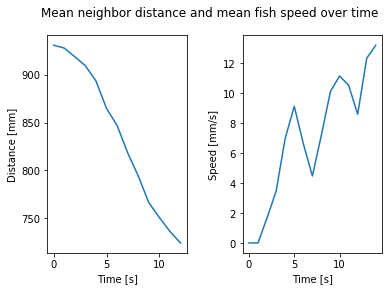

The initial mean neighbor distance is 930.7mm. The initial mean robot speed is 0.0mm/s
The final mean neighbor distance is 724.3mm. The final mean robot speed is 13.2mm/s
The reduction in mean neighbor distance is 22.2%


In [75]:
d_mean = observer.d_mean

data = np.zeros((6, run_time, num_fish))
data[0, :, :] = np.transpose(np.array(observer.x))
data[1, :, :] = np.transpose(np.array(observer.y))
data[2, :, :] = np.transpose(np.array(observer.z))
data[3, :, :] = np.transpose(np.array(observer.vx))
data[4, :, :] = np.transpose(np.array(observer.vy))
data[5, :, :] = np.transpose(np.array(observer.vz))

vx_mean = np.sum(data[3, :, :], axis=1)/num_fish
vy_mean = np.sum(data[4, :, :], axis=1)/num_fish
vz_mean = np.sum(data[5, :, :], axis=1)/num_fish

v_mean = np.array([vx_mean, vy_mean, vz_mean])
v_mean_magnitude = np.linalg.norm(v_mean, axis=0)

fig, axs = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4)

axs[0].plot(d_mean[2:])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Distance [mm]')
axs[1].plot(v_mean_magnitude)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Speed [mm/s]')
fig.suptitle('Mean neighbor distance and mean fish speed over time')
plt.show()

print('The initial mean neighbor distance is {0:.1f}mm. The initial mean robot speed is {1:.1f}mm/s'.format(d_mean[2], v_mean_magnitude[0]))
print('The final mean neighbor distance is {0:.1f}mm. The final mean robot speed is {1:.1f}mm/s'.format(d_mean[-1], v_mean_magnitude[-1]))
print('The reduction in mean neighbor distance is {0:.1f}%'.format((1-d_mean[-1]/d_mean[2])*100))

## Prepare Data for Animation

In [24]:
# Get fish data from observer
data = np.zeros((6, run_time, num_fish))
data[0, :, :] = np.transpose(np.array(observer.x))
data[1, :, :] = np.transpose(np.array(observer.y))
data[2, :, :] = np.transpose(np.array(observer.z))
data[3, :, :] = np.transpose(np.array(observer.vx))
data[4, :, :] = np.transpose(np.array(observer.vy))
data[5, :, :] = np.transpose(np.array(observer.vz))

## Save Data

In [25]:
np.save('occlusion', data)

## Animate Simulated Data

Change the speed-up factor of the animation in the variable `speed`. 

In [8]:
# Imports
import ipyvolume as ipv
from ipyvolume.moviemaker import MovieMaker
import ipywidgets as widgets
import ipywebrtc as webrtc
import matplotlib.cm as cm
import time

# Data handling
x, y, z, vx, vy, vz = data
speed = 10 # speed up animation 10 times

# Colors
colors[:, -2:, :] = cm.Reds(0.5) # one robot is red
colors[:, -1:, :] = cm.Blues(0.5) # one robot is blue

# Figure
fig = ipv.figure()
ipv.xlim(0, 1780)
ipv.ylim(0, 1780)
ipv.zlim(0, 1170)
ipv.style.use('dark')
quiver = ipv.quiver(x, y, z, vx, vy, vz, size=10, color=colors[:,:,:3])
ipv.animation_control(quiver, interval=1000/speed)
ipv.show()

ModuleNotFoundError: No module named 'ipyvolume'

## Save Animation as html

In [ ]:
ipv.save('occlusion.html')
!open 'occlusion.html'